# AirBnb - feature importance

## Key Steps for the Project
Following the CRISP-DM process.

1. Picking a dataset, as mentioned on the previous page.
2. Proposing at least three questions related to business or real-world applications of how the data could be used.
3. Creating a Jupyter Notebook, using any associated packages to:
    * Prepare data:
    * Gather necessary data to answer your questions
    * Handle categorical and missing data
    * Provide insight into the methods you chose and why you chose them
    * Analyze, Model, and Visualize
    * Provide a clear connection between your business questions and how the data answers them
4. Communicating business insights:
    * Create a Github repository to share your code and data wrangling/modeling techniques, with a technical audience in mind
    * Create a blog post to share your questions and insights with a non-technical audience

## Business Understanding

### Research questions
* Which are the most relevant characteristics of an accomodation related to the availability?
* How is the relation of the tourism appeal of the city and the renting characteristics?
* How does the geographical regions relates to the characteristics of the offered accomodation on AirBnb?

### Data Collection
The data which is used in this project is the AirBnb data from the following cities:
1. AustinAustin, Texas, United States
2. Boston, Massachusetts, United States
3. Chicago, Illinois, United States
4. Los Angeles, California, United States
5. Nashville, Tennessee, United States
6. New Orleans, Louisiana, United States
8. San Francisco, California, United States
9. Seattle, Washington, United States

The data was collected though this [link](http://insideairbnb.com/get-the-data.html).<br>

For each city the data collected are:
1. calendar
    * listing_id
    * date
    * available
    * price

2. listings
    * id
    * listing_url
    * scrape_id
    * last_scraped
    * name
    * summary
    * space
    * description
    * experiences_offered
    * neighborhood_overview
    * notes
    * transit
    * thumbnail_url
    * medium_url
    * picture_url
    * xl_picture_url
    * host_id
    * host_url
    * host_name
    * host_since
    * host_location
    * host_about
    * host_response_time
    * host_response_rate
    * host_acceptance_rate
    * host_is_superhost
    * host_thumbnail_url
    * host_picture_url
    * host_neighbourhood
    * host_listings_count
    * host_total_listings_count
    * host_verifications
    * host_has_profile_pic
    * host_identity_verified
    * street
    * neighbourhood
    * neighbourhood_cleansed
    * neighbourhood_group_cleansed
    * city
    * state
    * zipcode
    * market
    * smart_location
    * country_code
    * country
    * latitude
    * longitude
    * is_location_exact
    * property_type
    * room_type
    * accommodates
    * bathrooms
    * bedrooms
    * beds
    * bed_type
    * amenities
    * square_feet
    * price
    * weekly_price
    * monthly_price
    * security_deposit
    * cleaning_fee
    * guests_included
    * extra_people
    * minimum_nights
    * maximum_nights
    * calendar_updated
    * has_availability
    * availability_30
    * availability_60
    * availability_90
    * availability_365
    * calendar_last_scraped
    * number_of_reviews
    * first_review
    * last_review
    * review_scores_rating
    * review_scores_accuracy
    * review_scores_cleanliness
    * review_scores_checkin
    * review_scores_communication
    * review_scores_location
    * review_scores_value
    * requires_license
    * license
    * jurisdiction_names
    * instant_bookable
    * cancellation_policy
    * require_guest_profile_picture
    * require_guest_phone_verification
    * calculated_host_listings_count
    * reviews_per_month

3. reviews
    * listing_id
    * id
    * date
    * reviewer_id
    * reviewer_name
    * comments

To perform the analysis further information about the cities to be analysed was gathered from [this article](https://finance.yahoo.com/news/30-most-visited-cities-u-145000465.html).<br>

City|Foreign tourists in 2019|US Ranking of most visited cities
--| -- | -- 
Austin, Texas, United States|<200.000|>30
Boston, Massachusetts, United States|1.567.000|9
Chicago, Illinois, United States|1.491.000|10
Los Angeles, California, United States|4.645.000|3
Nashville, Tennessee, United States|<200.000|>30
New Orleans, Louisiana, United States|436.000|23
San Francisco, California, United States|3.308.000|5
Seattle, Washington, United States|844.000|14

The idea is to analyse the influence of the tourism appeal of each city on the AirBnb's customer behavior and on the availabilty rates of the offered accomodations.



## Importing libraries

In [50]:
import pandas as pd
import numpy as np
import gzip
from io import BytesIO
import re
from decimal import Decimal

import seaborn as sns
import matplotlib.pyplot as plt

import nltk
nltk.download('vader_lexicon')
from nltk.sentiment.vader import SentimentIntensityAnalyzer

from tqdm import tqdm

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.metrics import r2_score, mean_squared_error

import lightgbm as lgb
from xgboost import XGBRegressor


[nltk_data] Downloading package vader_lexicon to C:\Users\DTI
[nltk_data]     Digital\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


In [2]:
pd.set_option('display.max_columns', None)

## Toolkit functions

In [3]:
def remove_nonnumeric_chars(s):
    '''
    INPUT:
    s - numeric string with non-numeric charachters

    OUTPUT:
    np.float16 - numeric value before the dot
    '''
    try:
        return np.float64(Decimal(re.sub(r'[^\d.]', '', s)))
    except:
        return np.nan

In [4]:
def create_dummy_df(df, cat_cols, dummy_na, drop_first=True):
    '''
    INPUT:
    df - pandas dataframe with categorical variables you want to dummy
    cat_cols - list of strings that are associated with names of the categorical columns
    dummy_na - Bool holding whether you want to dummy NA vals of categorical columns or not
    
    OUTPUT:
    df - a new dataframe that has the following characteristics:
            1. contains all columns that were not specified as categorical
            2. removes all the original columns in cat_cols
            3. dummy columns for each of the categorical columns in cat_cols
            4. if dummy_na is True - it also contains dummy columns for the NaN values
            5. Use a prefix of the column name with an underscore (_) for separating 
    '''
    
    cat_df_out = pd.get_dummies(df[cat_cols], prefix=cat_cols, prefix_sep='_', dummy_na=dummy_na, drop_first=drop_first)
    df_out     = cat_df_out.join(df.drop(cat_cols, axis=1))

    return df_out

In [5]:
def get_sequences(vector, split_val):
    ''''
    INPUT:
    vector - raw serie (pd.Series)
    split_val - reference str to split the series

    OUTPUT:
    median, mean, max, min values of the sequences found in the serie
    '''    
    sequences = ''.join([str(val) for val in vector]).split(split_val)
    sequences_count = [len(val) for val in sequences]
    sequences_cleansed = [val for val in sequences_count if val>0]

    if len(sequences_cleansed) > 0:
        return np.median(sequences_cleansed), np.mean(sequences_cleansed), np.max(sequences_cleansed), np.min(sequences_cleansed)
    else:
        return 0,0,0,0

In [67]:
def plot_importance(data, feature, title=None ,rows=15):
    '''
    INPUT:
    data - dataframe based on which the plot will be done
    feature - feature to plot
    title - plot title, default=None
    rows - number of rows to show
    '''
    corr_abs = data.iloc[:rows]
    fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(5,7), dpi=400)#, sharey=True)
    gs = fig.add_gridspec(1, 3)

    sns.heatmap(corr_abs, annot=True, cmap='magma_r', cbar=False,ax=ax[0])
    sns.barplot(x=feature, y=corr_abs.index, data=corr_abs, palette="magma")

    ax[0].axes.get_xaxis().set_visible(False)
    ax[1].axes.get_xaxis().set_visible(False)
    ax[1].axes.get_yaxis().set_visible(False)

    fig.suptitle(title, fontsize=20)
    sns.despine(bottom=True)

## Data Understanding

### Load Data

#### calendar data

##### Load

In [6]:
city = 'austin'
calendar_path = f'datasets/raw/{city}/calendar.csv.gz'

with gzip.open(calendar_path,'r') as f:
    df_calendar = pd.read_csv(BytesIO(f.read()))

Check head

In [7]:
# show head of calendar dataframe
df_calendar.head()

,listing_id,date,available,price,adjusted_price,minimum_nights,maximum_nights
0,1078,2021-12-11,f,$120.00,$120.00,1.0,1125.0
1,1078,2021-12-12,f,$95.00,$95.00,1.0,1125.0
2,1078,2021-12-13,f,$95.00,$95.00,1.0,1125.0
3,1078,2021-12-14,f,$95.00,$95.00,1.0,1125.0
4,1078,2021-12-15,f,$95.00,$95.00,1.0,1125.0


Check types

In [8]:
df_calendar.info(show_counts=True, verbose=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4151151 entries, 0 to 4151150
Data columns (total 7 columns):
 #   Column          Non-Null Count    Dtype  
---  ------          --------------    -----  
 0   listing_id      4151151 non-null  int64  
 1   date            4151151 non-null  object 
 2   available       4151151 non-null  object 
 3   price           4151151 non-null  object 
 4   adjusted_price  4151151 non-null  object 
 5   minimum_nights  4151147 non-null  float64
 6   maximum_nights  4151147 non-null  float64
dtypes: float64(2), int64(1), object(4)
memory usage: 221.7+ MB


##### Check NaN values

In [9]:
columns = df_calendar.columns
for col in columns:
    print(f'{col} : {df_calendar[col].isna().mean()}')

listing_id : 0.0
date : 0.0
available : 0.0
price : 0.0
adjusted_price : 0.0
minimum_nights : 9.635881710879705e-07
maximum_nights : 9.635881710879705e-07


Since there are proportionally just a few missing values, it is not a big deal to drop those rows

In [10]:
df_calendar.dropna(inplace=True)

##### Checking types

We need to clean the "price" and the "adjusted_price" columns to transform the numeric string into numeric values

In [11]:
# object to numeric transformation
toNumeric_columns =  ['price','adjusted_price']
for col in toNumeric_columns:
    df_calendar[col] = df_calendar[col].apply(remove_nonnumeric_chars)

# str to datetime transformation
df_calendar['date'] = pd.to_datetime(df_calendar['date'])

##### Categorical Variables

In [12]:
cat_cols_lst = ['available']
df_calendar = create_dummy_df(df_calendar, cat_cols_lst, dummy_na=False)

##### Aggregating by accomodation

In [13]:
df_calendar_agg = df_calendar.groupby('listing_id').agg({'date':['min','max'],
                                                        'price':['min', 'max', 'mean'], 
                                                        'minimum_nights':['min','max','mean'], 
                                                        'maximum_nights':['min','max'],
                                                        'available_t':'sum'
                                                        })

In [14]:
df_calendar_agg.head()

date             price                    minimum_nights  \
                  min        max    min    max        mean            min   
listing_id                                                                  
1078       2021-12-11 2022-12-10   95.0  120.0  102.191781            1.0   
2265       2021-12-11 2022-12-10  170.0  200.0  178.630137            7.0   
5245       2021-12-11 2022-12-10  100.0  150.0  114.383562           30.0   
5456       2021-12-11 2022-12-10   95.0  250.0  116.438356            2.0   
5769       2021-12-11 2022-12-10   39.0   41.0   39.682192            1.0   

                       maximum_nights         available_t  
             max  mean            min     max         sum  
listing_id                                                 
1078         1.0   1.0         1125.0  1125.0         0.0  
2265         7.0   7.0          180.0   180.0         0.0  
5245        30.0  30.0           90.0    90.0         0.0  
5456         2.0   2.0           90.0    90.0       345.0  
5769         1.0   1.0           14.0    14.0         0.0

Renaming aggregated columns

In [15]:
# concat agg column names
col_names = []
for cols in df_calendar_agg.columns:
    new_col = '_'.join(cols)
    col_names.append(new_col)


# rename columns
df_calendar_agg.columns = col_names

df_calendar_agg.head()

,date_min,date_max,price_min,price_max,price_mean,minimum_nights_min,minimum_nights_max,minimum_nights_mean,maximum_nights_min,maximum_nights_max,available_t_sum
listing_id,,,,,,,,,,,
1078,2021-12-11,2022-12-10,95.0,120.0,102.191781,1.0,1.0,1.0,1125.0,1125.0,0.0
2265,2021-12-11,2022-12-10,170.0,200.0,178.630137,7.0,7.0,7.0,180.0,180.0,0.0
5245,2021-12-11,2022-12-10,100.0,150.0,114.383562,30.0,30.0,30.0,90.0,90.0,0.0
5456,2021-12-11,2022-12-10,95.0,250.0,116.438356,2.0,2.0,2.0,90.0,90.0,345.0
5769,2021-12-11,2022-12-10,39.0,41.0,39.682192,1.0,1.0,1.0,14.0,14.0,0.0


##### Feature engineering

In [16]:
# number of days online
df_calendar_agg['online_days'] = (df_calendar_agg['date_max']-df_calendar_agg['date_min']).apply(lambda x: x.days)+1
# occupied days
df_calendar_agg['ocupied_days'] = df_calendar_agg['online_days'] - df_calendar_agg['available_t_sum']
# total revenue generated by the allocation
df_calendar_agg['revenue'] = df_calendar_agg['ocupied_days']*df_calendar_agg['price_mean']
# ocupation rate
df_calendar_agg['ocupation_rate'] = df_calendar_agg['ocupied_days'] / df_calendar_agg['online_days']
# geographical data
df_calendar_agg['city'] = city
# ocupation duration stats
ocupation_duration_stats = pd.DataFrame()

d = {'listing_id':[],
        'ocupation_duration_median':[],
        'ocupation_duration_mean':[],
        'ocupation_duration_max':[],
        'ocupation_duration_min':[]
        }
    
for listing_id in df_calendar_agg.index:

    vector = df_calendar.loc[df_calendar['listing_id']==listing_id]['available_t']
    median_val, mean_val, max_val, min_val = get_sequences(vector, '1')
    d['listing_id'].append(listing_id) 
    d['ocupation_duration_median'].append(median_val)
    d['ocupation_duration_mean'].append(mean_val)
    d['ocupation_duration_max'].append(max_val)
    d['ocupation_duration_min'].append(min_val)


ocupation_duration_stats = pd.DataFrame(d)
df_calendar_agg = df_calendar_agg.join(ocupation_duration_stats.set_index('listing_id'))   




In [17]:
ocupation_duration_stats.tail()

,listing_id,ocupation_duration_median,ocupation_duration_mean,ocupation_duration_max,ocupation_duration_min
11368,53760016,1.0,1.0,1,1
11369,53764066,32.0,32.0,32,32
11370,53767190,0.0,0.0,0,0
11371,53769566,6.5,56.5,300,2
11372,53770692,7.0,7.0,7,7


<AxesSubplot:xlabel='ocupation_duration_mean', ylabel='Count'>

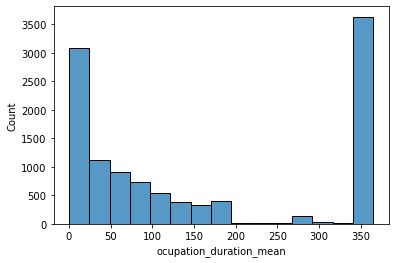

In [18]:
sns.histplot(x='ocupation_duration_mean', data=ocupation_duration_stats)

<AxesSubplot:xlabel='ocupation_duration_mean', ylabel='Count'>

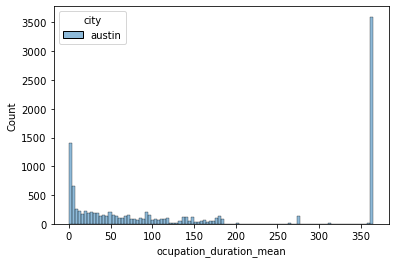

In [19]:
sns.histplot(x='ocupation_duration_mean', data=df_calendar_agg, hue='city', bins=100)

In [20]:
df_calendar_agg.shape

(11373, 20)

##### Ingesting Pipeline - Calendar

In [21]:
tourism_ranking = {'city':            ['austin', 'boston', 'chicago', 'los_angeles', 'nashville', 'new_orleans',  'new_york', 'san_francisco', 'seattle'],
                   'tourism_ranking' :[40,        9,        10,        3,            40,          23,             1,          5,               14       ],
                   'foreign_visitors':[200000,    1567000,  1491000,   4645000,      200000,      436000,         10288000,   3308000,         844000   ]
                    }

In [22]:
tourism = pd.DataFrame(tourism_ranking)

In [23]:
df_calendar_agg.join(tourism.set_index('city'), on='city', how='left')

,date_min,date_max,price_min,price_max,price_mean,minimum_nights_min,minimum_nights_max,minimum_nights_mean,maximum_nights_min,maximum_nights_max,available_t_sum,online_days,ocupied_days,revenue,ocupation_rate,city,ocupation_duration_median,ocupation_duration_mean,ocupation_duration_max,ocupation_duration_min,tourism_ranking,foreign_visitors
listing_id,,,,,,,,,,,,,,,,,,,,,,
1078,2021-12-11,2022-12-10,95.0,120.0,102.191781,1.0,1.0,1.000000,1125.0,1125.0,0.0,365,365.0,37300.000000,1.000000,austin,365.0,365.0,365,365,40,200000
2265,2021-12-11,2022-12-10,170.0,200.0,178.630137,7.0,7.0,7.000000,180.0,180.0,0.0,365,365.0,65200.000000,1.000000,austin,365.0,365.0,365,365,40,200000
5245,2021-12-11,2022-12-10,100.0,150.0,114.383562,30.0,30.0,30.000000,90.0,90.0,0.0,365,365.0,41750.000000,1.000000,austin,365.0,365.0,365,365,40,200000
5456,2021-12-11,2022-12-10,95.0,250.0,116.438356,2.0,2.0,2.000000,90.0,90.0,345.0,365,20.0,2328.767123,0.054795,austin,4.0,4.0,7,1,40,200000
5769,2021-12-11,2022-12-10,39.0,41.0,39.682192,1.0,1.0,1.000000,14.0,14.0,0.0,365,365.0,14484.000000,1.000000,austin,365.0,365.0,365,365,40,200000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
53760016,2021-12-12,2022-12-11,413.0,413.0,413.000000,9.0,9.0,9.000000,365.0,365.0,362.0,365,3.0,1239.000000,0.008219,austin,1.0,1.0,1,1,40,200000
53764066,2021-12-11,2022-12-10,192.0,238.0,206.347945,31.0,730.0,700.320548,1125.0,1125.0,333.0,365,32.0,6603.134247,0.087671,austin,32.0,32.0,32,32,40,200000
53767190,2021-12-11,2022-12-10,56.0,56.0,56.000000,90.0,90.0,90.000000,365.0,365.0,365.0,365,0.0,0.000000,0.000000,austin,0.0,0.0,0,0,40,200000


In [24]:
trusted_calendar_dataset = pd.DataFrame()

cities = ['austin', 'boston', 'chicago', 'los_angeles', 'nashville', 'new_orleans',  'new_york', 'san_francisco', 'seattle']

region = {'austin':'south', 
          'boston':'north_east', 
          'chicago':'north_east', 
          'los_angeles':'west', 
          'nashville':'south', 
          'new_orleans':'south',  
          'new_york':'north_east', 
          'san_francisco':'west', 
          'seattle':'west'}

tourism = {'city':            ['austin', 'boston', 'chicago', 'los_angeles', 'nashville', 'new_orleans',  'new_york', 'san_francisco', 'seattle'],
           'tourism_ranking' :[40,        9,        10,        3,            40,          23,             1,          5,               14       ],
           'foreign_visitors':[200000,    1567000,  1491000,   4645000,      200000,      436000,         10288000,   3308000,         844000   ]
           }

tourism = pd.DataFrame(tourism)

for city in tqdm(cities):
    # defining path to read data
    calendar_path = f'datasets/raw/{city}/calendar.csv.gz'

    # extracting data
    with gzip.open(calendar_path,'r') as f:
        df_calendar = pd.read_csv(BytesIO(f.read()))

    # dropping NaN values (not much missing values)
    df_calendar.dropna(inplace=True)
    
    # object to numeric transformation
    toNumeric_columns =  ['price','adjusted_price']
    for col in toNumeric_columns:
        df_calendar[col] = df_calendar[col].apply(remove_nonnumeric_chars)

    # str to datetime transformation
    df_calendar['date'] = pd.to_datetime(df_calendar['date'])

    # dealing with categorical values
    cat_cols_lst = ['available']
    df_calendar = create_dummy_df(df_calendar, cat_cols_lst, dummy_na=False)

    # Aggregating by listing_id
    df_calendar_agg = df_calendar.groupby('listing_id').agg({'date':['min','max'],
                                                        'price':['min', 'max', 'mean'], 
                                                        'minimum_nights':['min','max','mean'], 
                                                        'maximum_nights':['min','max'],
                                                        'available_t':'sum'
                                                        })  
    
    # Renaming aggregated columns
    # concat agg column names
    col_names = []
    for cols in df_calendar_agg.columns:
        new_col = '_'.join(cols)
        col_names.append(new_col)

    # rename columns
    df_calendar_agg.columns = col_names


    # Feature engineering
    # number of days online
    df_calendar_agg['online_days'] = (df_calendar_agg['date_max']-df_calendar_agg['date_min']).apply(lambda x: x.days)+1
    df_calendar_agg.drop('date_max', axis=1, inplace=True)
    df_calendar_agg.drop('date_min', axis=1, inplace=True)
    # occupied days
    df_calendar_agg['ocupied_days'] = df_calendar_agg['online_days'] - df_calendar_agg['available_t_sum']
    # total revenue generated by the allocation
    df_calendar_agg['revenue'] = df_calendar_agg['ocupied_days'] * df_calendar_agg['price_mean']
    # ocupation rate
    df_calendar_agg['ocupation_rate'] = df_calendar_agg['ocupied_days'] / df_calendar_agg['online_days']
    # geographical data
    df_calendar_agg['city'] = city
    df_calendar_agg['region'] = region[city]
    # tourism data
    df_calendar_agg = df_calendar_agg.join(tourism.set_index('city'), on='city', how='left')

    # calculating relative price based on each city
    df_calendar_agg['price_mean_rel'] = df_calendar_agg['price_mean'] / df_calendar_agg['price_mean'].mean()
    df_calendar_agg['price_min_rel'] = df_calendar_agg['price_min'] / df_calendar_agg['price_min'].mean()
    df_calendar_agg['price_max_rel'] = df_calendar_agg['price_max'] / df_calendar_agg['price_max'].mean()

    d = {'listing_id':[],
        'ocupation_duration_median':[],
        'ocupation_duration_mean':[],
        'ocupation_duration_max':[],
        'ocupation_duration_min':[]
        }
    
    for listing_id in df_calendar_agg.index:

        vector = df_calendar.loc[df_calendar['listing_id']==listing_id]['available_t']
        median_val, mean_val, max_val, min_val = get_sequences(vector, '1')
        d['listing_id'].append(listing_id) 
        d['ocupation_duration_median'].append(median_val)
        d['ocupation_duration_mean'].append(mean_val)
        d['ocupation_duration_max'].append(max_val)
        d['ocupation_duration_min'].append(min_val)
    
    ocupation_duration_stats = pd.DataFrame(d)
    df_calendar_agg = df_calendar_agg.join(ocupation_duration_stats.set_index('listing_id'))   

    # concat data to the calendar dataset
    trusted_calendar_dataset = pd.concat([trusted_calendar_dataset, df_calendar_agg])

# one hot encoding of city and region
cat_cols_lst = ['city','region']
trusted_calendar_dataset = create_dummy_df(trusted_calendar_dataset, cat_cols_lst, dummy_na=False, drop_first=False)

# loading data to the trusted directory
trusted_calendar_dataset.to_csv('datasets/trusted/calendar_dataset.csv')



    

100%|██████████| 9/9 [30:47<00:00, 205.32s/it]


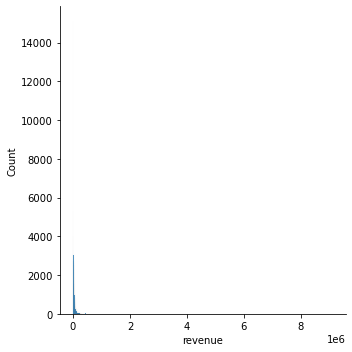

In [25]:
sns.displot(x='revenue', data=trusted_calendar_dataset)

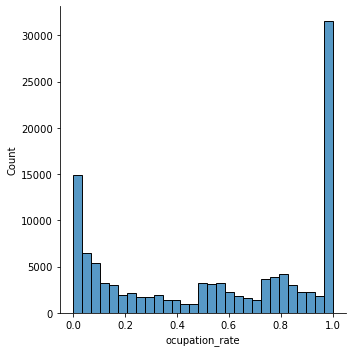

In [26]:
sns.displot(x='ocupation_rate', data=trusted_calendar_dataset)
# histplot(element='ocupation_rate', data=trusted_calendar_dataset, hue='city')

<AxesSubplot:xlabel='ocupation_duration_median', ylabel='Count'>

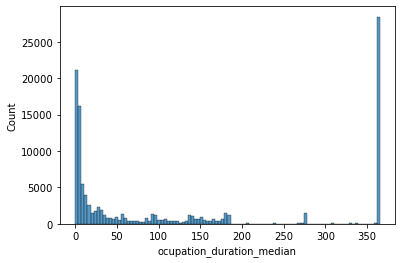

In [27]:
sns.histplot(x='ocupation_duration_median', data=trusted_calendar_dataset, bins=100)

<AxesSubplot:xlabel='ocupation_duration_mean', ylabel='Count'>

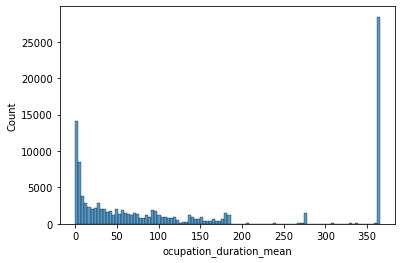

In [28]:
sns.histplot(x='ocupation_duration_mean', data=trusted_calendar_dataset, bins=100)

<AxesSubplot:xlabel='online_days', ylabel='Count'>

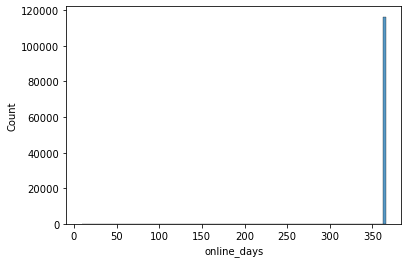

In [29]:
sns.histplot(data=trusted_calendar_dataset['online_days'], bins=100)

##### Findings
* Most of the allocations are in a very short term, but there are some that are in a very long term as well
* The Ocupation rate is low for most of the cases, but there are some long term allocations near to 100% in a considerable number of accomodations

#### listing data

##### Load

In [30]:
city = 'austin'
listing_path = f'datasets/raw/{city}/listings.csv.gz'

with gzip.open(listing_path,'r') as f:
    df_listing = pd.read_csv(BytesIO(f.read()))

Check data

In [31]:
df_listing.head()

,id,listing_url,scrape_id,last_scraped,name,description,neighborhood_overview,picture_url,host_id,host_url,host_name,host_since,host_location,host_about,host_response_time,host_response_rate,host_acceptance_rate,host_is_superhost,host_thumbnail_url,host_picture_url,host_neighbourhood,host_listings_count,host_total_listings_count,host_verifications,host_has_profile_pic,host_identity_verified,neighbourhood,neighbourhood_cleansed,neighbourhood_group_cleansed,latitude,longitude,property_type,room_type,accommodates,bathrooms,bathrooms_text,bedrooms,beds,amenities,price,minimum_nights,maximum_nights,minimum_minimum_nights,maximum_minimum_nights,minimum_maximum_nights,maximum_maximum_nights,minimum_nights_avg_ntm,maximum_nights_avg_ntm,calendar_updated,has_availability,availability_30,availability_60,availability_90,availability_365,calendar_last_scraped,number_of_reviews,number_of_reviews_ltm,number_of_reviews_l30d,first_review,last_review,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,license,instant_bookable,calculated_host_listings_count,calculated_host_listings_count_entire_homes,calculated_host_listings_count_private_rooms,calculated_host_listings_count_shared_rooms,reviews_per_month
0,1078,https://www.airbnb.com/rooms/1078,20211211051409,2021-12-11,*UT/Hyde Park Craftsman Apartment,This upstairs apartment is surrounded by trees...,"Hyde Park is close to downtown, UT, 6th street...",https://a0.muscache.com/pictures/52472f12-2e2e...,4635658,https://www.airbnb.com/users/show/4635658,Tracy,2013-01-08,"Austin, Texas, United States",I have been a super-host for about 10 years an...,within an hour,100%,100%,t,https://a0.muscache.com/im/users/4635658/profi...,https://a0.muscache.com/im/users/4635658/profi...,University of Texas,2.0,2.0,"['email', 'phone', 'reviews', 'offline_governm...",t,t,"Austin, Texas, United States",78705,NaN,30.30002,-97.73637,Entire guesthouse,Entire home/apt,2,NaN,1 bath,1.0,1.0,"[""Microwave"", ""Shampoo"", ""Long term stays allo...",$102.00,1,365,1.0,1.0,1125.0,1125.0,1.0,1125.0,NaN,t,0,0,0,0,2021-12-11,232,5,2,2008-09-13,2021-11-21,4.89,4.92,4.83,4.93,4.91,4.87,4.87,NaN,t,2,2,0,0,1.44
1,2265,https://www.airbnb.com/rooms/2265,20211211051409,2021-12-11,Zen-East in the Heart of Austin (monthly rental),Zen East is situated in a vibrant & diverse mu...,NaN,https://a0.muscache.com/pictures/4187/52d4f5d0...,2466,https://www.airbnb.com/users/show/2466,Paddy,2008-08-23,"Austin, Texas, United States",I am a long time resident of Austin. I earned ...,within a day,100%,70%,t,https://a0.muscache.com/im/users/2466/profile_...,https://a0.muscache.com/im/users/2466/profile_...,East Downtown,3.0,3.0,"['email', 'phone', 'facebook', 'reviews', 'kba']",t,t,NaN,78702,NaN,30.27752,-97.71377,Entire residential home,Entire home/apt,4,NaN,2 baths,2.0,2.0,"[""Microwave"", ""Paid parking off premises"", ""Cl...",$179.00,7,180,7.0,7.0,180.0,180.0,7.0,180.0,NaN,t,0,0,0,0,2021-12-11,26,2,0,2009-03-17,2021-07-02,4.68,4.74,4.83,4.77,4.83,4.26,4.35,NaN,f,3,2,1,0,0.17
2,5245,https://www.airbnb.com/rooms/5245,20211211051409,2021-12-11,"Eco friendly, Colorful, Clean, Cozy monthly share",Situated in a vibrant & diverse multicultural ...,NaN,https://a0.muscache.com/pictures/5167505/b33b5...,2466,https://www.airbnb.com/users/show/2466,Paddy,2008-08-23,"Austin, Texas, United States",I am a long time resident of Austin. I earned ...,within a day,100%,70%,t,https://a0.muscache.com/im/users/2466/profile_...,https://a0.muscache.com/im/users/2466/profile_...,East Downtown,3.0,3.0,"['email', 'phone', 'facebook', 'reviews', 'kba']",t,t,NaN,78702,NaN,30.27614,-97.71320,Private room in residential home,Private room,2,NaN,1 private bath,1.0,2.0,"[""TV with standard cable"", ""Shampoo"", ""Long te...",$114.00,30,90,30.0,30.0,90.0,90.0,30.0,90.0,NaN,t,0,0,0,0,2021-12-11,9,0,0,2009-03-19,2018-03-14,4.57,4.80,4.20,5.00,4.40,4.75,4.50,NaN,f,3,2,1,

In [32]:
df_listing[['property_type', 'room_type']].columns

Index(['property_type', 'room_type'], dtype='object')

In [33]:
df_listing.columns

Index(['id', 'listing_url', 'scrape_id', 'last_scraped', 'name', 'description',
       'neighborhood_overview', 'picture_url', 'host_id', 'host_url',
       'host_name', 'host_since', 'host_location', 'host_about',
       'host_response_time', 'host_response_rate', 'host_acceptance_rate',
       'host_is_superhost', 'host_thumbnail_url', 'host_picture_url',
       'host_neighbourhood', 'host_listings_count',
       'host_total_listings_count', 'host_verifications',
       'host_has_profile_pic', 'host_identity_verified', 'neighbourhood',
       'neighbourhood_cleansed', 'neighbourhood_group_cleansed', 'latitude',
       'longitude', 'property_type', 'room_type', 'accommodates', 'bathrooms',
       'bathrooms_text', 'bedrooms', 'beds', 'amenities', 'price',
       'minimum_nights', 'maximum_nights', 'minimum_minimum_nights',
       'maximum_minimum_nights', 'minimum_maximum_nights',
       'maximum_maximum_nights', 'minimum_nights_avg_ntm',
       'maximum_nights_avg_ntm', 'calendar_upd

Check types

In [34]:
df_listing.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11374 entries, 0 to 11373
Data columns (total 74 columns):
 #   Column                                        Non-Null Count  Dtype  
---  ------                                        --------------  -----  
 0   id                                            11374 non-null  int64  
 1   listing_url                                   11374 non-null  object 
 2   scrape_id                                     11374 non-null  int64  
 3   last_scraped                                  11374 non-null  object 
 4   name                                          11374 non-null  object 
 5   description                                   11165 non-null  object 
 6   neighborhood_overview                         6827 non-null   object 
 7   picture_url                                   11373 non-null  object 
 8   host_id                                       11374 non-null  int64  
 9   host_url                                      11374 non-null 

##### Check NaN values

In [35]:
# features without missing values
missing_cols_00 = df_listing.columns[df_listing.isna().mean()==0]
print(missing_cols_00)

Index(['id', 'listing_url', 'scrape_id', 'last_scraped', 'name', 'host_id',
       'host_url', 'host_verifications', 'neighbourhood_cleansed', 'latitude',
       'longitude', 'property_type', 'room_type', 'accommodates', 'amenities',
       'price', 'minimum_nights', 'maximum_nights', 'has_availability',
       'availability_30', 'availability_60', 'availability_90',
       'availability_365', 'calendar_last_scraped', 'number_of_reviews',
       'number_of_reviews_ltm', 'number_of_reviews_l30d', 'instant_bookable',
       'calculated_host_listings_count',
       'calculated_host_listings_count_entire_homes',
       'calculated_host_listings_count_private_rooms',
       'calculated_host_listings_count_shared_rooms'],
      dtype='object')


Deleting all the columns with 100% missings values

In [36]:
missing_cols_100 = df_listing.columns[df_listing.isna().mean()==1]
print(missing_cols_100)

Index(['neighbourhood_group_cleansed', 'bathrooms', 'calendar_updated',
       'license'],
      dtype='object')


In [37]:
df_listing.drop(missing_cols_100, axis=1, inplace=True)

In [38]:
missing_cols_50 = df_listing.columns[(df_listing.isna().mean()<0.5)&(df_listing.isna().mean()>0) ]
print(missing_cols_50)

Index(['description', 'neighborhood_overview', 'picture_url', 'host_name',
       'host_since', 'host_location', 'host_about', 'host_response_time',
       'host_response_rate', 'host_acceptance_rate', 'host_is_superhost',
       'host_thumbnail_url', 'host_picture_url', 'host_neighbourhood',
       'host_listings_count', 'host_total_listings_count',
       'host_has_profile_pic', 'host_identity_verified', 'neighbourhood',
       'bathrooms_text', 'bedrooms', 'beds', 'minimum_minimum_nights',
       'maximum_minimum_nights', 'minimum_maximum_nights',
       'maximum_maximum_nights', 'minimum_nights_avg_ntm',
       'maximum_nights_avg_ntm', 'first_review', 'last_review',
       'review_scores_rating', 'review_scores_accuracy',
       'review_scores_cleanliness', 'review_scores_checkin',
       'review_scores_communication', 'review_scores_location',
       'review_scores_value', 'reviews_per_month'],
      dtype='object')


In [39]:
# counting the number of missing values of the <50% >0% group
df_listing[missing_cols_50].isna().mean().sort_values(ascending=False)


neighbourhood                  0.399771
neighborhood_overview          0.399771
host_about                     0.394760
host_response_rate             0.390276
host_response_time             0.390276
host_acceptance_rate           0.351416
review_scores_location         0.231317
review_scores_value            0.231317
review_scores_checkin          0.231229
review_scores_communication    0.231141
review_scores_cleanliness      0.231141
review_scores_accuracy         0.231141
review_scores_rating           0.223580
last_review                    0.223580
first_review                   0.223580
reviews_per_month              0.223580
host_neighbourhood             0.157728
bedrooms                       0.063214
beds                           0.029189
description                    0.018375
host_location                  0.005803
host_identity_verified         0.004572
host_has_profile_pic           0.004572
host_name                      0.004572
host_since                     0.004572


In [40]:
# for the ones below 5%, dropping the rows
to_drop_rows = df_listing.columns[(df_listing.isna().mean()<0.1)]
df_listing.dropna(subset=to_drop_rows, inplace=True)

Gross transformation and column filtering 

In [41]:
object_cols = df_listing.columns[df_listing.dtypes=='object']
print(object_cols)

Index(['listing_url', 'last_scraped', 'name', 'description',
       'neighborhood_overview', 'picture_url', 'host_url', 'host_name',
       'host_since', 'host_location', 'host_about', 'host_response_time',
       'host_response_rate', 'host_acceptance_rate', 'host_is_superhost',
       'host_thumbnail_url', 'host_picture_url', 'host_neighbourhood',
       'host_verifications', 'host_has_profile_pic', 'host_identity_verified',
       'neighbourhood', 'property_type', 'room_type', 'bathrooms_text',
       'amenities', 'price', 'has_availability', 'calendar_last_scraped',
       'first_review', 'last_review', 'instant_bookable'],
      dtype='object')


In [42]:
# verifying the host data
host_info = [col for col in object_cols if 'host' in col]
df_listing[host_info].head()

,host_url,host_name,host_since,host_location,host_about,host_response_time,host_response_rate,host_acceptance_rate,host_is_superhost,host_thumbnail_url,host_picture_url,host_neighbourhood,host_verifications,host_has_profile_pic,host_identity_verified
0,https://www.airbnb.com/users/show/4635658,Tracy,2013-01-08,"Austin, Texas, United States",I have been a super-host for about 10 years an...,within an hour,100%,100%,t,https://a0.muscache.com/im/users/4635658/profi...,https://a0.muscache.com/im/users/4635658/profi...,University of Texas,"['email', 'phone', 'reviews', 'offline_governm...",t,t
1,https://www.airbnb.com/users/show/2466,Paddy,2008-08-23,"Austin, Texas, United States",I am a long time resident of Austin. I earned ...,within a day,100%,70%,t,https://a0.muscache.com/im/users/2466/profile_...,https://a0.muscache.com/im/users/2466/profile_...,East Downtown,"['email', 'phone', 'facebook', 'reviews', 'kba']",t,t
2,https://www.airbnb.com/users/show/2466,Paddy,2008-08-23,"Austin, Texas, United States",I am a long time resident of Austin. I earned ...,within a day,100%,70%,t,https://a0.muscache.com/im/users/2466/profile_...,https://a0.muscache.com/im/users/2466/profile_...,East Downtown,"['email', 'phone', 'facebook', 'reviews', 'kba']",t,t
3,https://www.airbnb.com/users/show/8028,Sylvia,2009-02-16,"Austin, Texas, United States",I am a licensed Real Estate Broker and owner o...,within a few hours,100%,94%,t,https://a0.muscache.com/im/users/8028/profile_...,https://a0.muscache.com/im/users/8028/profile_...,East Downtown,"['email', 'phone', 'reviews', 'kba']",t,t
4,https://www.airbnb.com/users/show/8186,Elizabeth,2009-02-19,"Austin, Texas, United States",We're easygoing professionals that enjoy meeti...,NaN,NaN,100%,t,https://a0.muscache.com/im/users/8186/profile_...,https://a0.muscache.com/im/users/8186/profile_...,SW Williamson Co.,"['email', 'phone', 'reviews', 'jumio', 'govern...",t,t


In [43]:
# cleansing host data
to_drop = ['host_url', 'host_name', 'host_location', 'host_about', 'host_thumbnail_url', 'host_picture_url', 'host_neighbourhood', 'host_verifications']
df_listing.drop(to_drop, axis=1, inplace=True)


In [44]:
object_not_host = [col for col in object_cols if col not in host_info]
df_listing[object_not_host].head(2)

,listing_url,last_scraped,name,description,neighborhood_overview,picture_url,neighbourhood,property_type,room_type,bathrooms_text,amenities,price,has_availability,calendar_last_scraped,first_review,last_review,instant_bookable
0,https://www.airbnb.com/rooms/1078,2021-12-11,*UT/Hyde Park Craftsman Apartment,This upstairs apartment is surrounded by trees...,"Hyde Park is close to downtown, UT, 6th street...",https://a0.muscache.com/pictures/52472f12-2e2e...,"Austin, Texas, United States",Entire guesthouse,Entire home/apt,1 bath,"[""Microwave"", ""Shampoo"", ""Long term stays allo...",$102.00,t,2021-12-11,2008-09-13,2021-11-21,t
1,https://www.airbnb.com/rooms/2265,2021-12-11,Zen-East in the Heart of Austin (monthly rental),Zen East is situated in a vibrant & diverse mu...,NaN,https://a0.muscache.com/pictures/4187/52d4f5d0...,NaN,Entire residential home,Entire home/apt,2 baths,"[""Microwave"", ""Paid parking off premises"", ""Cl...",$179.00,t,2021-12-11,2009-03-17,2021-07-02,f


In [47]:
to_drop = ['listing_url', 'name', 'description', 'picture_url', 'neighbourhood', 'amenities', 'price', 'has_availability',
           'neighborhood_overview','calendar_last_scraped','last_review','property_type','license','neighbourhood_group_cleansed',
           'bathrooms_text']

df_listing.drop([col for col in to_drop if col in df_listing.columns], axis=1, inplace=True)

In [48]:
non_object_cols = df_listing.columns[df_listing.dtypes!='object']
df_listing[non_object_cols].head(2)

,id,scrape_id,host_id,host_listings_count,host_total_listings_count,neighbourhood_cleansed,latitude,longitude,accommodates,bedrooms,beds,minimum_nights,maximum_nights,minimum_minimum_nights,maximum_minimum_nights,minimum_maximum_nights,maximum_maximum_nights,minimum_nights_avg_ntm,maximum_nights_avg_ntm,availability_30,availability_60,availability_90,availability_365,number_of_reviews,number_of_reviews_ltm,number_of_reviews_l30d,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,calculated_host_listings_count,calculated_host_listings_count_entire_homes,calculated_host_listings_count_private_rooms,calculated_host_listings_count_shared_rooms,reviews_per_month
0,1078,20211211051409,4635658,2.0,2.0,78705,30.30002,-97.73637,2,1.0,1.0,1,365,1.0,1.0,1125.0,1125.0,1.0,1125.0,0,0,0,0,232,5,2,4.89,4.92,4.83,4.93,4.91,4.87,4.87,2,2,0,0,1.44
1,2265,20211211051409,2466,3.0,3.0,78702,30.27752,-97.71377,4,2.0,2.0,7,180,7.0,7.0,180.0,180.0,7.0,180.0,0,0,0,0,26,2,0,4.68,4.74,4.83,4.77,4.83,4.26,4.35,3,2,1,0,0.17


In [49]:
non_object_cols

Index(['id', 'scrape_id', 'host_id', 'host_listings_count',
       'host_total_listings_count', 'neighbourhood_cleansed', 'latitude',
       'longitude', 'accommodates', 'bedrooms', 'beds', 'minimum_nights',
       'maximum_nights', 'minimum_minimum_nights', 'maximum_minimum_nights',
       'minimum_maximum_nights', 'maximum_maximum_nights',
       'minimum_nights_avg_ntm', 'maximum_nights_avg_ntm', 'availability_30',
       'availability_60', 'availability_90', 'availability_365',
       'number_of_reviews', 'number_of_reviews_ltm', 'number_of_reviews_l30d',
       'review_scores_rating', 'review_scores_accuracy',
       'review_scores_cleanliness', 'review_scores_checkin',
       'review_scores_communication', 'review_scores_location',
       'review_scores_value', 'calculated_host_listings_count',
       'calculated_host_listings_count_entire_homes',
       'calculated_host_listings_count_private_rooms',
       'calculated_host_listings_count_shared_rooms', 'reviews_per_month'],
   

In [50]:
to_drop = ['scrape_id', 'host_id', 'host_listings_count', 'host_total_listings_count', 'neighbourhood_cleansed', 'latitude', 'longitude', 'minimum_nights',
            'maximum_nights','minimum_minimum_nights','maximum_minimum_nights','minimum_maximum_nights','maximum_maximum_nights','minimum_nights_avg_ntm','maximum_nights_avg_ntm',
            'availability_30','availability_60','availability_365','availability_90','number_of_reviews_ltm','number_of_reviews_l30d','calculated_host_listings_count','calculated_host_listings_count_entire_homes',
            'calculated_host_listings_count_shared_rooms','calculated_host_listings_count_private_rooms', 'last_scraped']
df_listing.drop(to_drop, axis=1, inplace=True)

In [51]:
df_listing.shape

(10105, 23)

Fine transformation of the attributes

In [52]:
df_listing.head(3)

,id,host_since,host_response_time,host_response_rate,host_acceptance_rate,host_is_superhost,host_has_profile_pic,host_identity_verified,room_type,accommodates,bedrooms,beds,number_of_reviews,first_review,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,instant_bookable,reviews_per_month
0,1078,2013-01-08,within an hour,100%,100%,t,t,t,Entire home/apt,2,1.0,1.0,232,2008-09-13,4.89,4.92,4.83,4.93,4.91,4.87,4.87,t,1.44
1,2265,2008-08-23,within a day,100%,70%,t,t,t,Entire home/apt,4,2.0,2.0,26,2009-03-17,4.68,4.74,4.83,4.77,4.83,4.26,4.35,f,0.17
2,5245,2008-08-23,within a day,100%,70%,t,t,t,Private room,2,1.0,2.0,9,2009-03-19,4.57,4.80,4.20,5.00,4.40,4.75,4.50,f,0.06


In [53]:
categorical_cols = ['host_response_time', 'host_is_superhost', 'host_has_profile_pic', 'host_identity_verified', 'property_type', 'room_type', 'instant_bookable']
date_cols = ['host_since','first_review']

In [54]:
df_listing.isna().mean().sort_values(ascending=False)

host_response_time             0.388026
host_response_rate             0.388026
host_acceptance_rate           0.347947
review_scores_value            0.226620
review_scores_location         0.226620
review_scores_checkin          0.226522
review_scores_communication    0.226423
review_scores_cleanliness      0.226423
review_scores_accuracy         0.226423
reviews_per_month              0.219792
first_review                   0.219792
review_scores_rating           0.219792
instant_bookable               0.000000
id                             0.000000
number_of_reviews              0.000000
host_since                     0.000000
bedrooms                       0.000000
accommodates                   0.000000
room_type                      0.000000
host_identity_verified         0.000000
host_has_profile_pic           0.000000
host_is_superhost              0.000000
beds                           0.000000
dtype: float64

Dealing with categorical variables

In [56]:
df_listing = create_dummy_df(df_listing, 
                               [col for col in categorical_cols if col in df_listing.columns] , dummy_na=True)

Transforming object numeric values into numeric values  

In [57]:
# object to numeric transformation
toNumeric_columns =  ['host_response_rate','host_acceptance_rate']
for col in toNumeric_columns:
    df_listing[col] = df_listing[col].apply(remove_nonnumeric_chars)


Transforming the date features from object to datetime

In [58]:
# str to datetime transformation
for col in date_cols:
    df_listing[col] = pd.to_datetime(df_listing[col])

Dealing with missing values

In [59]:
df_listing['first_review'] = df_listing['first_review'].fillna(np.mean(df_listing['first_review']))
df_listing = df_listing.fillna(df_listing.median())

C:\Users\DTIDIG~1\AppData\Local\Temp/ipykernel_33292/3834483111.py:2: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  df_listing = df_listing.fillna(df_listing.median())


In [60]:
df_listing.columns[df_listing.isna().mean()>0]

Index([], dtype='object')

In [61]:
df_listing.shape

(10105, 33)

##### Feature engineering

In [62]:
df_listing.head()

,host_response_time_within a day,host_response_time_within a few hours,host_response_time_within an hour,host_response_time_nan,host_is_superhost_t,host_is_superhost_nan,host_has_profile_pic_t,host_has_profile_pic_nan,host_identity_verified_t,host_identity_verified_nan,room_type_Hotel room,room_type_Private room,room_type_Shared room,room_type_nan,instant_bookable_t,instant_bookable_nan,id,host_since,host_response_rate,host_acceptance_rate,accommodates,bedrooms,beds,number_of_reviews,first_review,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,reviews_per_month
0,0,0,1,0,1,0,1,0,1,0,0,0,0,0,1,0,1078,2013-01-08,100.0,100.0,2,1.0,1.0,232,2008-09-13,4.89,4.92,4.83,4.93,4.91,4.87,4.87,1.44
1,1,0,0,0,1,0,1,0,1,0,0,0,0,0,0,0,2265,2008-08-23,100.0,70.0,4,2.0,2.0,26,2009-03-17,4.68,4.74,4.83,4.77,4.83,4.26,4.35,0.17
2,1,0,0,0,1,0,1,0,1,0,0,1,0,0,0,0,5245,2008-08-23,100.0,70.0,2,1.0,2.0,9,2009-03-19,4.57,4.80,4.20,5.00,4.40,4.75,4.50,0.06
3,0,1,0,0,1,0,1,0,1,0,0,0,0,0,0,0,5456,2009-02-16,100.0,94.0,3,1.0,2.0,578,2009-03-08,4.83,4.87,4.84,4.89,4.80,4.73,4.78,3.72
4,0,0,0,1,1,0,1,0,1,0,0,1,0,0,0,0,5769,2009-02-19,100.0,100.0,2,1.0,1.0,264,2010-04-10,4.90,4.90,4.86,4.91,4.94,4.74,4.92,1.86


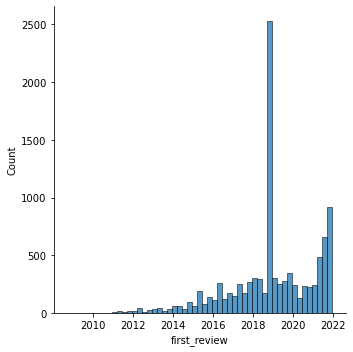

In [63]:
sns.displot(data=df_listing, x='first_review')

Most of the first reviews are new, which seams to show a trend of increasing the number of reviews over time

In [64]:
df_listing['first_review'] = (df_listing['first_review'].max()-df_listing['first_review']).apply(lambda x: x.days)

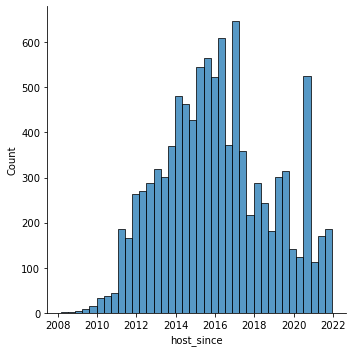

In [65]:
sns.displot(data=df_listing, x='host_since')

Most of the hosts are hosts between 2000 and 3000 days, which means since between 5 and 8 years

In [66]:
df_listing['host_since'] = (df_listing['host_since'].max()-df_listing['host_since']).apply(lambda x: x.days)

##### Ingesting pipeline Listings Data

In [67]:
trusted_listing_dataset = pd.DataFrame()

cities = ['austin', 'boston', 'chicago', 'los_angeles', 'nashville', 'new_orleans',  'new_york', 'san_francisco', 'seattle']

region = {'austin':'south', 
          'boston':'north_east', 
          'chicago':'north_east', 
          'los_angeles':'west', 
          'nashville':'south', 
          'new_orleans':'south',  
          'new_york':'north_east', 
          'san_francisco':'west', 
          'seattle':'west'}

for city in tqdm(cities):
    # defining path to read data
    listing_path = f'datasets/raw/{city}/listings.csv.gz'

    with gzip.open(listing_path,'r') as f:
        df_listing = pd.read_csv(BytesIO(f.read()))

    missing_cols_100 = df_listing.columns[df_listing.isna().mean()==1]
    df_listing.drop(missing_cols_100, axis=1, inplace=True)

    # for the ones below 5%, dropping the rows
    to_drop_rows = df_listing.columns[(df_listing.isna().mean()<0.1)]
    df_listing.dropna(subset=to_drop_rows, inplace=True)

    object_cols = df_listing.columns[df_listing.dtypes=='object']

    # cleansing host data
    to_drop = ['host_url', 'host_name', 'host_location', 'host_about', 'host_thumbnail_url', 'host_picture_url', 'host_neighbourhood', 'host_verifications']
    df_listing.drop(to_drop, axis=1, inplace=True)

    to_drop = ['listing_url', 'name', 'description', 'picture_url', 'neighbourhood', 'amenities', 'price', 'has_availability',
           'neighborhood_overview','calendar_last_scraped','last_review',
           'bathrooms_text']
    df_listing.drop(to_drop, axis=1, inplace=True)

    to_drop = ['scrape_id', 'host_id', 'host_listings_count', 'host_total_listings_count', 'neighbourhood_cleansed', 'latitude', 'longitude', 'minimum_nights',
            'maximum_nights','minimum_minimum_nights','maximum_minimum_nights','minimum_maximum_nights','maximum_maximum_nights','minimum_nights_avg_ntm','maximum_nights_avg_ntm',
            'availability_30','availability_60','availability_365','availability_90','number_of_reviews_ltm','number_of_reviews_l30d','calculated_host_listings_count','calculated_host_listings_count_entire_homes',
            'calculated_host_listings_count_shared_rooms','calculated_host_listings_count_private_rooms', 'last_scraped']
    df_listing.drop(to_drop, axis=1, inplace=True)


    categorical_cols = ['host_response_time', 'host_is_superhost', 'host_has_profile_pic', 'host_identity_verified', 'room_type', 'instant_bookable']
    date_cols = ['host_since','first_review']

    df_listing = create_dummy_df(df_listing, categorical_cols, dummy_na=True)

    # object to numeric transformation
    toNumeric_columns =  ['host_response_rate','host_acceptance_rate']
    for col in toNumeric_columns:
        df_listing[col] = df_listing[col].apply(remove_nonnumeric_chars)

    # str to datetime transformation
    for col in date_cols:
        df_listing[col] = pd.to_datetime(df_listing[col])

    # imputing the mean value to the missing values
    df_listing['first_review'] = df_listing['first_review'].fillna(np.mean(df_listing['first_review']))
    # imputing the median value to the missing values
    df_listing = df_listing.fillna(df_listing.median())

    # transforming the date into the number of days until the last date
    for col in date_cols:
        df_listing[col] = (df_listing[col].max()-df_listing[col]).apply(lambda x: x.days)

    trusted_listing_dataset = pd.concat([trusted_listing_dataset, df_listing])

for col in ['license','neighbourhood_group_cleansed', 'property_type']:
    try:
        trusted_listing_dataset.drop(col, axis=1, inplace=True)
    except:
        print(f'{col} not found in axis')

trusted_listing_dataset = trusted_listing_dataset.fillna(trusted_listing_dataset.median())
    
# loading data to the trusted directory
trusted_listing_dataset.to_csv('datasets/trusted/listing_dataset.csv')

    

  0%|          | 0/9 [00:00<?, ?it/s]C:\Users\DTIDIG~1\AppData\Local\Temp/ipykernel_33292/3074421056.py:64: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  df_listing = df_listing.fillna(df_listing.median())
C:\Users\DTIDIG~1\AppData\Local\Temp/ipykernel_33292/3074421056.py:64: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  df_listing = df_listing.fillna(df_listing.median())
 11%|█         | 1/9 [00:00<00:07,  1.01it/s]C:\Users\DTIDIG~1\AppData\Local\Temp/ipykernel_33292/3074421056.py:64: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  df_listing = df_listing.fillna(df_listing.median())
C:\Users\DTIDIG~1\AppData\Local\Temp/ipyk

#### reviews

##### Load

In [68]:
city = 'austin'
reviews_path = f'datasets/raw/{city}/reviews.csv.gz'

with gzip.open(reviews_path,'r') as f:
    df_reviews = pd.read_csv(BytesIO(f.read()))

Check Loading

In [69]:
df_reviews.head()

,listing_id,id,date,reviewer_id,reviewer_name,comments
0,1078,142,2008-09-13,1344,Amy,A fabulously cozy place! It was slightly diff...
1,1078,207074,2011-03-22,451657,Angela,perfect!---:) Will stay again!
2,1078,217779,2011-04-04,473682,Jennifer,I had a great stay at Brian's garden apartment...
3,1078,6841593,2013-08-26,8153398,Kathryn,The reservation was canceled 19 days before ar...
4,1078,7071134,2013-09-05,420381,Rita,Fantastic Experience! My daughter and I staye...


Check types

In [70]:
df_reviews.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 382362 entries, 0 to 382361
Data columns (total 6 columns):
 #   Column         Non-Null Count   Dtype 
---  ------         --------------   ----- 
 0   listing_id     382362 non-null  int64 
 1   id             382362 non-null  int64 
 2   date           382362 non-null  object
 3   reviewer_id    382362 non-null  int64 
 4   reviewer_name  382362 non-null  object
 5   comments       382065 non-null  object
dtypes: int64(3), object(3)
memory usage: 17.5+ MB


##### Check NaN values


In [71]:
df_reviews.isna().mean().sort_values(ascending=False)

comments         0.000777
listing_id       0.000000
id               0.000000
date             0.000000
reviewer_id      0.000000
reviewer_name    0.000000
dtype: float64

Dropping the nan values, since there are few missing values

In [72]:
df_reviews.dropna(inplace=True)

In [73]:
df_reviews.shape

(382065, 6)

Dropping useless columns

In [74]:
df_reviews.drop(['id', 'reviewer_id',	'reviewer_name'], axis=1, inplace=True)

##### Feature Engineering

In [75]:
# performing sentiment analysis on the comments given
sid = SentimentIntensityAnalyzer()

df_reviews["review_comment_score"] = df_reviews['comments'].apply(sid.polarity_scores)
df_reviews["review_comment_score"] = df_reviews["review_comment_score"].apply(lambda review: review['compound'])

In [76]:
# transforming the date into the number of days until the last date
df_reviews['date'] = pd.to_datetime(df_reviews['date'])
df_reviews['review_date'] = (df_reviews['date'].max()-df_reviews['date']).apply(lambda x: x.days)

In [77]:
# dropping the transformed columns
df_reviews.drop(['date','comments'], axis=1, inplace=True)

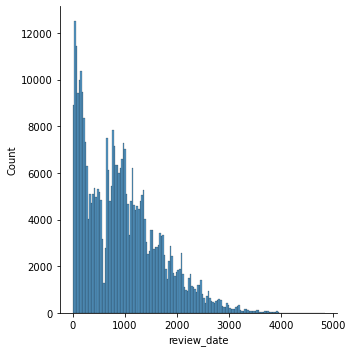

In [78]:
sns.displot(x="review_date", data=df_reviews)

The distribution of reviews is right skewed, what means that most of them are newer.

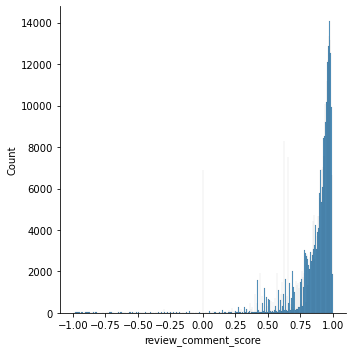

In [79]:
sns.displot(x="review_comment_score", data=df_reviews)

The majority of comments are positive, but there are also some really negative.

##### Grouping by listing_id

In [80]:
df_reviews_agg = df_reviews.groupby('listing_id').agg({'review_comment_score':['min','max','mean','median'],
                                                       'review_date':['min', 'max', 'mean','median'], 
                                                       })

Renaming aggregated columns

In [81]:
# concat agg column names
col_names = []
for cols in df_reviews_agg.columns:
    new_col = '_'.join(cols)
    col_names.append(new_col)


# rename columns
df_reviews_agg.columns = col_names

df_reviews_agg.head()

,review_comment_score_min,review_comment_score_max,review_comment_score_mean,review_comment_score_median,review_date_min,review_date_max,review_date_mean,review_date_median
listing_id,,,,,,,,
1078,-0.1027,0.9971,0.881062,0.94070,20,4837,2092.387931,2099.5
2265,-0.0615,0.9871,0.871335,0.93740,162,4652,2324.615385,2175.5
5245,0.0000,0.9841,0.759822,0.92640,1368,4650,2869.333333,2545.0
5456,-0.9231,0.9973,0.874044,0.93365,23,4661,2401.847751,2403.0
5769,-0.5719,0.9967,0.886028,0.93505,161,4263,2554.242424,2702.0


In [82]:
df_reviews.head()

,listing_id,review_comment_score,review_date
0,1078,0.9634,4837
1,1078,0.0000,3917
2,1078,0.9188,3904
3,1078,0.0000,3029
4,1078,0.9917,3019


##### Ingesting Pipeline - Reviews

In [83]:
trusted_reviews_dataset = pd.DataFrame()

cities = ['austin', 'boston', 'chicago', 'los_angeles', 'nashville', 'new_orleans',  'new_york', 'san_francisco', 'seattle']

region = {'austin':'south', 
          'boston':'north_east', 
          'chicago':'north_east', 
          'los_angeles':'west', 
          'nashville':'south', 
          'new_orleans':'south',  
          'new_york':'north_east', 
          'san_francisco':'west', 
          'seattle':'west'}

for city in tqdm(cities):
    # defining path to read data
    reviews_path = f'datasets/raw/{city}/reviews.csv.gz'

    with gzip.open(reviews_path,'r') as f:
        df_reviews = pd.read_csv(BytesIO(f.read()))

    # dropping nan values
    df_reviews.dropna(inplace=True)
    # dropping useless columns
    df_reviews.drop(['id', 'reviewer_id',	'reviewer_name'], axis=1, inplace=True)

    # performing sentiment analysis on the comments given
    sid = SentimentIntensityAnalyzer()

    df_reviews["review_comment_score"] = df_reviews['comments'].apply(sid.polarity_scores)
    df_reviews["review_comment_score"] = df_reviews["review_comment_score"].apply(lambda review: review['compound'])

    # transforming the date into the number of days until the last date
    df_reviews['date'] = pd.to_datetime(df_reviews['date'])
    df_reviews['review_date'] = (df_reviews['date'].max()-df_reviews['date']).apply(lambda x: x.days)

    # dropping the transformed columns
    df_reviews.drop(['date','comments'], axis=1, inplace=True)

    # Grouping by listing_id
    df_reviews_agg = df_reviews.groupby('listing_id').agg({'review_comment_score':['min','max','mean','median'],
                                                       'review_date':['min', 'max', 'mean','median'], 
                                                       })
    # concat agg column names
    col_names = []
    for cols in df_reviews_agg.columns:
        new_col = '_'.join(cols)
        col_names.append(new_col)
    # rename columns
    df_reviews_agg.columns = col_names

    # concat data to the reviews dataset
    trusted_reviews_dataset = pd.concat([trusted_reviews_dataset, df_reviews_agg])

# loading data to the trusted directory
trusted_reviews_dataset.to_csv('datasets/trusted/reviews_dataset.csv')
    

100%|██████████| 9/9 [38:55<00:00, 259.54s/it]


## Data Preparation

Joining all the datasets on listings_id

In [21]:
calendar_path = 'datasets/trusted/calendar_dataset.csv'
listing_path = 'datasets/trusted/listing_dataset.csv'
reviews_path = 'datasets/trusted/reviews_dataset.csv'

calendar_trusted = pd.read_csv(calendar_path)
listing_trusted = pd.read_csv(listing_path)
reviews_trusted = pd.read_csv(reviews_path)

In [85]:
print(calendar_trusted.isna().mean().sort_values(ascending=False))
print(calendar_trusted.shape)

city_boston                  0.971230
city_seattle                 0.959746
city_new_orleans             0.948116
city_nashville               0.945340
city_san_francisco           0.944893
city_chicago                 0.943750
city_austin                  0.902241
region_south                 0.795697
city_los_angeles             0.713548
city_new_york                0.671136
region_west                  0.618187
region_north_east            0.586116
price_mean_rel               0.000000
ocupation_duration_min       0.000000
ocupation_duration_max       0.000000
ocupation_duration_mean      0.000000
ocupation_duration_median    0.000000
price_max_rel                0.000000
price_min_rel                0.000000
listing_id                   0.000000
foreign_visitors             0.000000
minimum_nights_max           0.000000
date_min                     0.000000
date_max                     0.000000
price_min                    0.000000
price_max                    0.000000
price_mean  

In [86]:
print(listing_trusted.isna().mean().sort_values(ascending=False))
print(listing_trusted.shape)

Unnamed: 0                               0.0
first_review                             0.0
host_response_rate                       0.0
host_acceptance_rate                     0.0
accommodates                             0.0
bedrooms                                 0.0
beds                                     0.0
number_of_reviews                        0.0
review_scores_rating                     0.0
host_response_time_within a day          0.0
review_scores_accuracy                   0.0
review_scores_cleanliness                0.0
review_scores_checkin                    0.0
review_scores_communication              0.0
review_scores_location                   0.0
review_scores_value                      0.0
host_since                               0.0
id                                       0.0
instant_bookable_nan                     0.0
instant_bookable_t                       0.0
room_type_nan                            0.0
room_type_Shared room                    0.0
room_type_

In [87]:
print(reviews_trusted.isna().mean().sort_values(ascending=False))
print(reviews_trusted.shape)

listing_id                     0.0
review_comment_score_min       0.0
review_comment_score_max       0.0
review_comment_score_mean      0.0
review_comment_score_median    0.0
review_date_min                0.0
review_date_max                0.0
review_date_mean               0.0
review_date_median             0.0
dtype: float64
(90764, 9)


In [88]:
df_refined = reviews_trusted.set_index('listing_id').join(listing_trusted.set_index('id'), how='left').join(calendar_trusted.set_index('listing_id'), how='left')

In [25]:
print(df_refined.dropna().shape)
print(df_refined.shape)
print(df_refined.dropna().shape[0] / df_refined.shape[0])

(82895, 78)
(90764, 78)
0.9133026309990745


In [16]:
df_refined[[col for col in df_refined.columns if 'region' in col]]

,region_south,region_north_east,region_west
0,1.0,0.0,0.0
1,1.0,0.0,0.0
2,1.0,0.0,0.0
3,1.0,0.0,0.0
4,1.0,0.0,0.0
...,...,...,...
90759,0.0,0.0,1.0
90760,0.0,0.0,1.0
90761,0.0,0.0,1.0
90762,0.0,0.0,1.0


In [13]:
# fill nan values with 0 for city and region
# df_refined[[col for col in df_refined.columns if 'city' in col]] = df_refined[[col for col in df_refined.columns if 'city' in col]].fillna(0)

In [15]:
# df_refined[[col for col in df_refined.columns if 'region' in col]] = df_refined[[col for col in df_refined.columns if 'region' in col]].fillna(0)

In [26]:
# drop nan values before persisting dataset
df_refined.dropna(inplace=True)

In [37]:
df_refined.columns[df_refined.dtypes=='object']

Index(['date_min', 'date_max'], dtype='object')

In [27]:
df_refined.to_csv('datasets/refined/refined_dataset.csv')

## Modelling

In [28]:
df_refined = pd.read_csv('datasets/refined/refined_dataset.csv')

In [29]:
df_refined.head()

,Unnamed: 0,listing_id,review_comment_score_min,review_comment_score_max,review_comment_score_mean,review_comment_score_median,review_date_min,review_date_max,review_date_mean,review_date_median,...,city_boston,region_north_east,city_chicago,city_los_angeles,region_west,city_nashville,city_new_orleans,city_new_york,city_san_francisco,city_seattle
0,0,1078,-0.1027,0.9971,0.881062,0.94070,20,4837,2092.387931,2099.5,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1,2265,-0.0615,0.9871,0.871335,0.93740,162,4652,2324.615385,2175.5,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,2,5245,0.0000,0.9841,0.759822,0.92640,1368,4650,2869.333333,2545.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,3,5456,-0.9231,0.9973,0.874044,0.93365,23,4661,2401.847751,2403.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,4,5769,-0.5719,0.9967,0.886028,0.93505,161,4263,2554.242424,2702.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [33]:
df_refined[['revenue']].describe()

,revenue
count,8.289500e+04
mean,4.231726e+04
std,9.801016e+04
min,0.000000e+00
25%,9.889373e+03
50%,2.592307e+04
75%,4.910826e+04
max,9.125000e+06


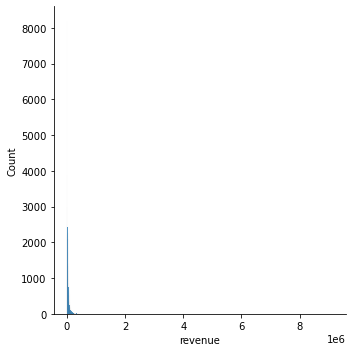

In [32]:
sns.displot(data=df_refined, x='revenue')

In [40]:
[col for col in df_refined.columns if 'date' in col]

['review_date_min',
 'review_date_max',
 'review_date_mean',
 'review_date_median',
 'accommodates',
 'date_min',
 'date_max']

In [42]:
scaler = StandardScaler()

X = df_refined.drop('revenue', axis=1)
y = df_refined['revenue']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=42)

X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

print(f'features X_train: {len(X_train[1])}\nfeatures X_test: {len(X_test[1])}')

features X_train: 76
features X_test: 76


In [43]:
lgbc = lgb.LGBMRegressor()
lgbc.fit(X_train, y_train)
lgbc_pred_train=lgbc.predict(X_train)
lgbc_pred_test=lgbc.predict(X_test)

In [44]:
xgbc = XGBRegressor()
xgbc.fit(X_train, y_train)
xgbc_pred_train=xgbc.predict(X_train)
xgbc_pred_test=xgbc.predict(X_test)

In [45]:
xgscore = np.mean(cross_val_score(estimator=xgbc,
                       X=X_train, y=y_train, cv=5))
lgbmscore = np.mean(cross_val_score(estimator=lgbc,
                       X=X_train, y=y_train, cv=5))

In [46]:
print(f'XGBoost score: {xgscore}')
print(f'LightGBM score: {lgbmscore}')

XGBoost score: 0.9952068484912789
LightGBM score: 0.9555728760342316


In [48]:
train_score_xgbc =  r2_score(y_train, xgbc_pred_train)
test_score_xgbc = r2_score(y_test, xgbc_pred_test)

train_score_lgbc =  r2_score(y_train, lgbc_pred_train)
test_score_lgbc = r2_score(y_test, lgbc_pred_test)

train_test_results = [{'train r2 score':train_score_xgbc,
                       'test r2 score': test_score_xgbc,
                       'model':'XGBRegressor'},
                       {'train r2 score':train_score_lgbc,
                       'test r2 score': test_score_lgbc,
                       'model':'LGBMRegressor'},
                      ]
train_test_results = pd.DataFrame(train_test_results)

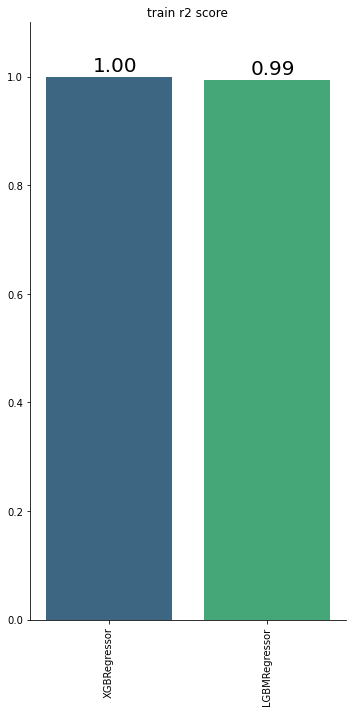

In [61]:
plt.figure(figsize=(5,10))
ax = sns.barplot(x='model', y='train r2 score', data=train_test_results, palette='viridis')
plt.xlabel('')
plt.ylabel('')
plt.title('train r2 score')
plt.xticks(rotation=90)
plt.ylim(0,1.1)
plt.tight_layout()
for p in ax.patches:
    ax.annotate('{:.2f}'.format(p.get_height()), (p.get_x()+0.3, p.get_height()+0.01), fontsize=20)
sns.despine()

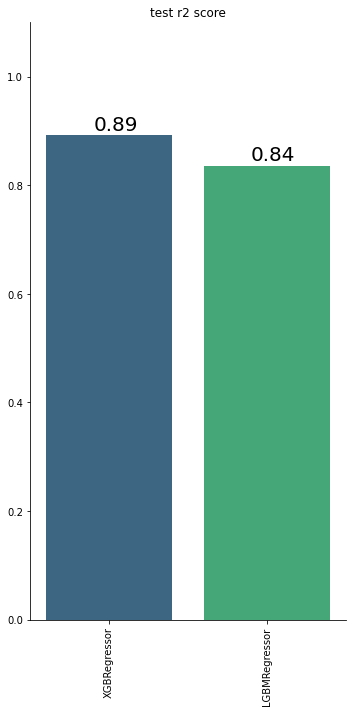

In [63]:
plt.figure(figsize=(5,10))
ax = sns.barplot(x='model', y='test r2 score', data=train_test_results, palette='viridis')
plt.xlabel('')
plt.ylabel('')
plt.title('test r2 score')
plt.xticks(rotation=90)
plt.ylim(0,1.1)
plt.tight_layout()
for p in ax.patches:
    ax.annotate('{:.2f}'.format(p.get_height()), (p.get_x()+0.3, p.get_height()+0.01), fontsize=20)
sns.despine()

In [64]:
most_important_LightGBM = pd.DataFrame(lgbc.booster_.feature_importance(importance_type="gain"), index=X.columns, columns=['Total gain'])
most_important_LightGBM = most_important_LightGBM.sort_values(ascending=False, by='Total gain')

In [65]:
dict_importance = xgbc.get_booster().get_score(importance_type="total_gain")
d={}

for index, value in dict_importance.items():
    d[X.columns[int(index[1:])]] = value
    
most_important_XGBoost = pd.DataFrame(d, index=['Total gain']).T
most_important_XGBoost = most_important_XGBoost[['Total gain']].sort_values(ascending=False, by='Total gain')

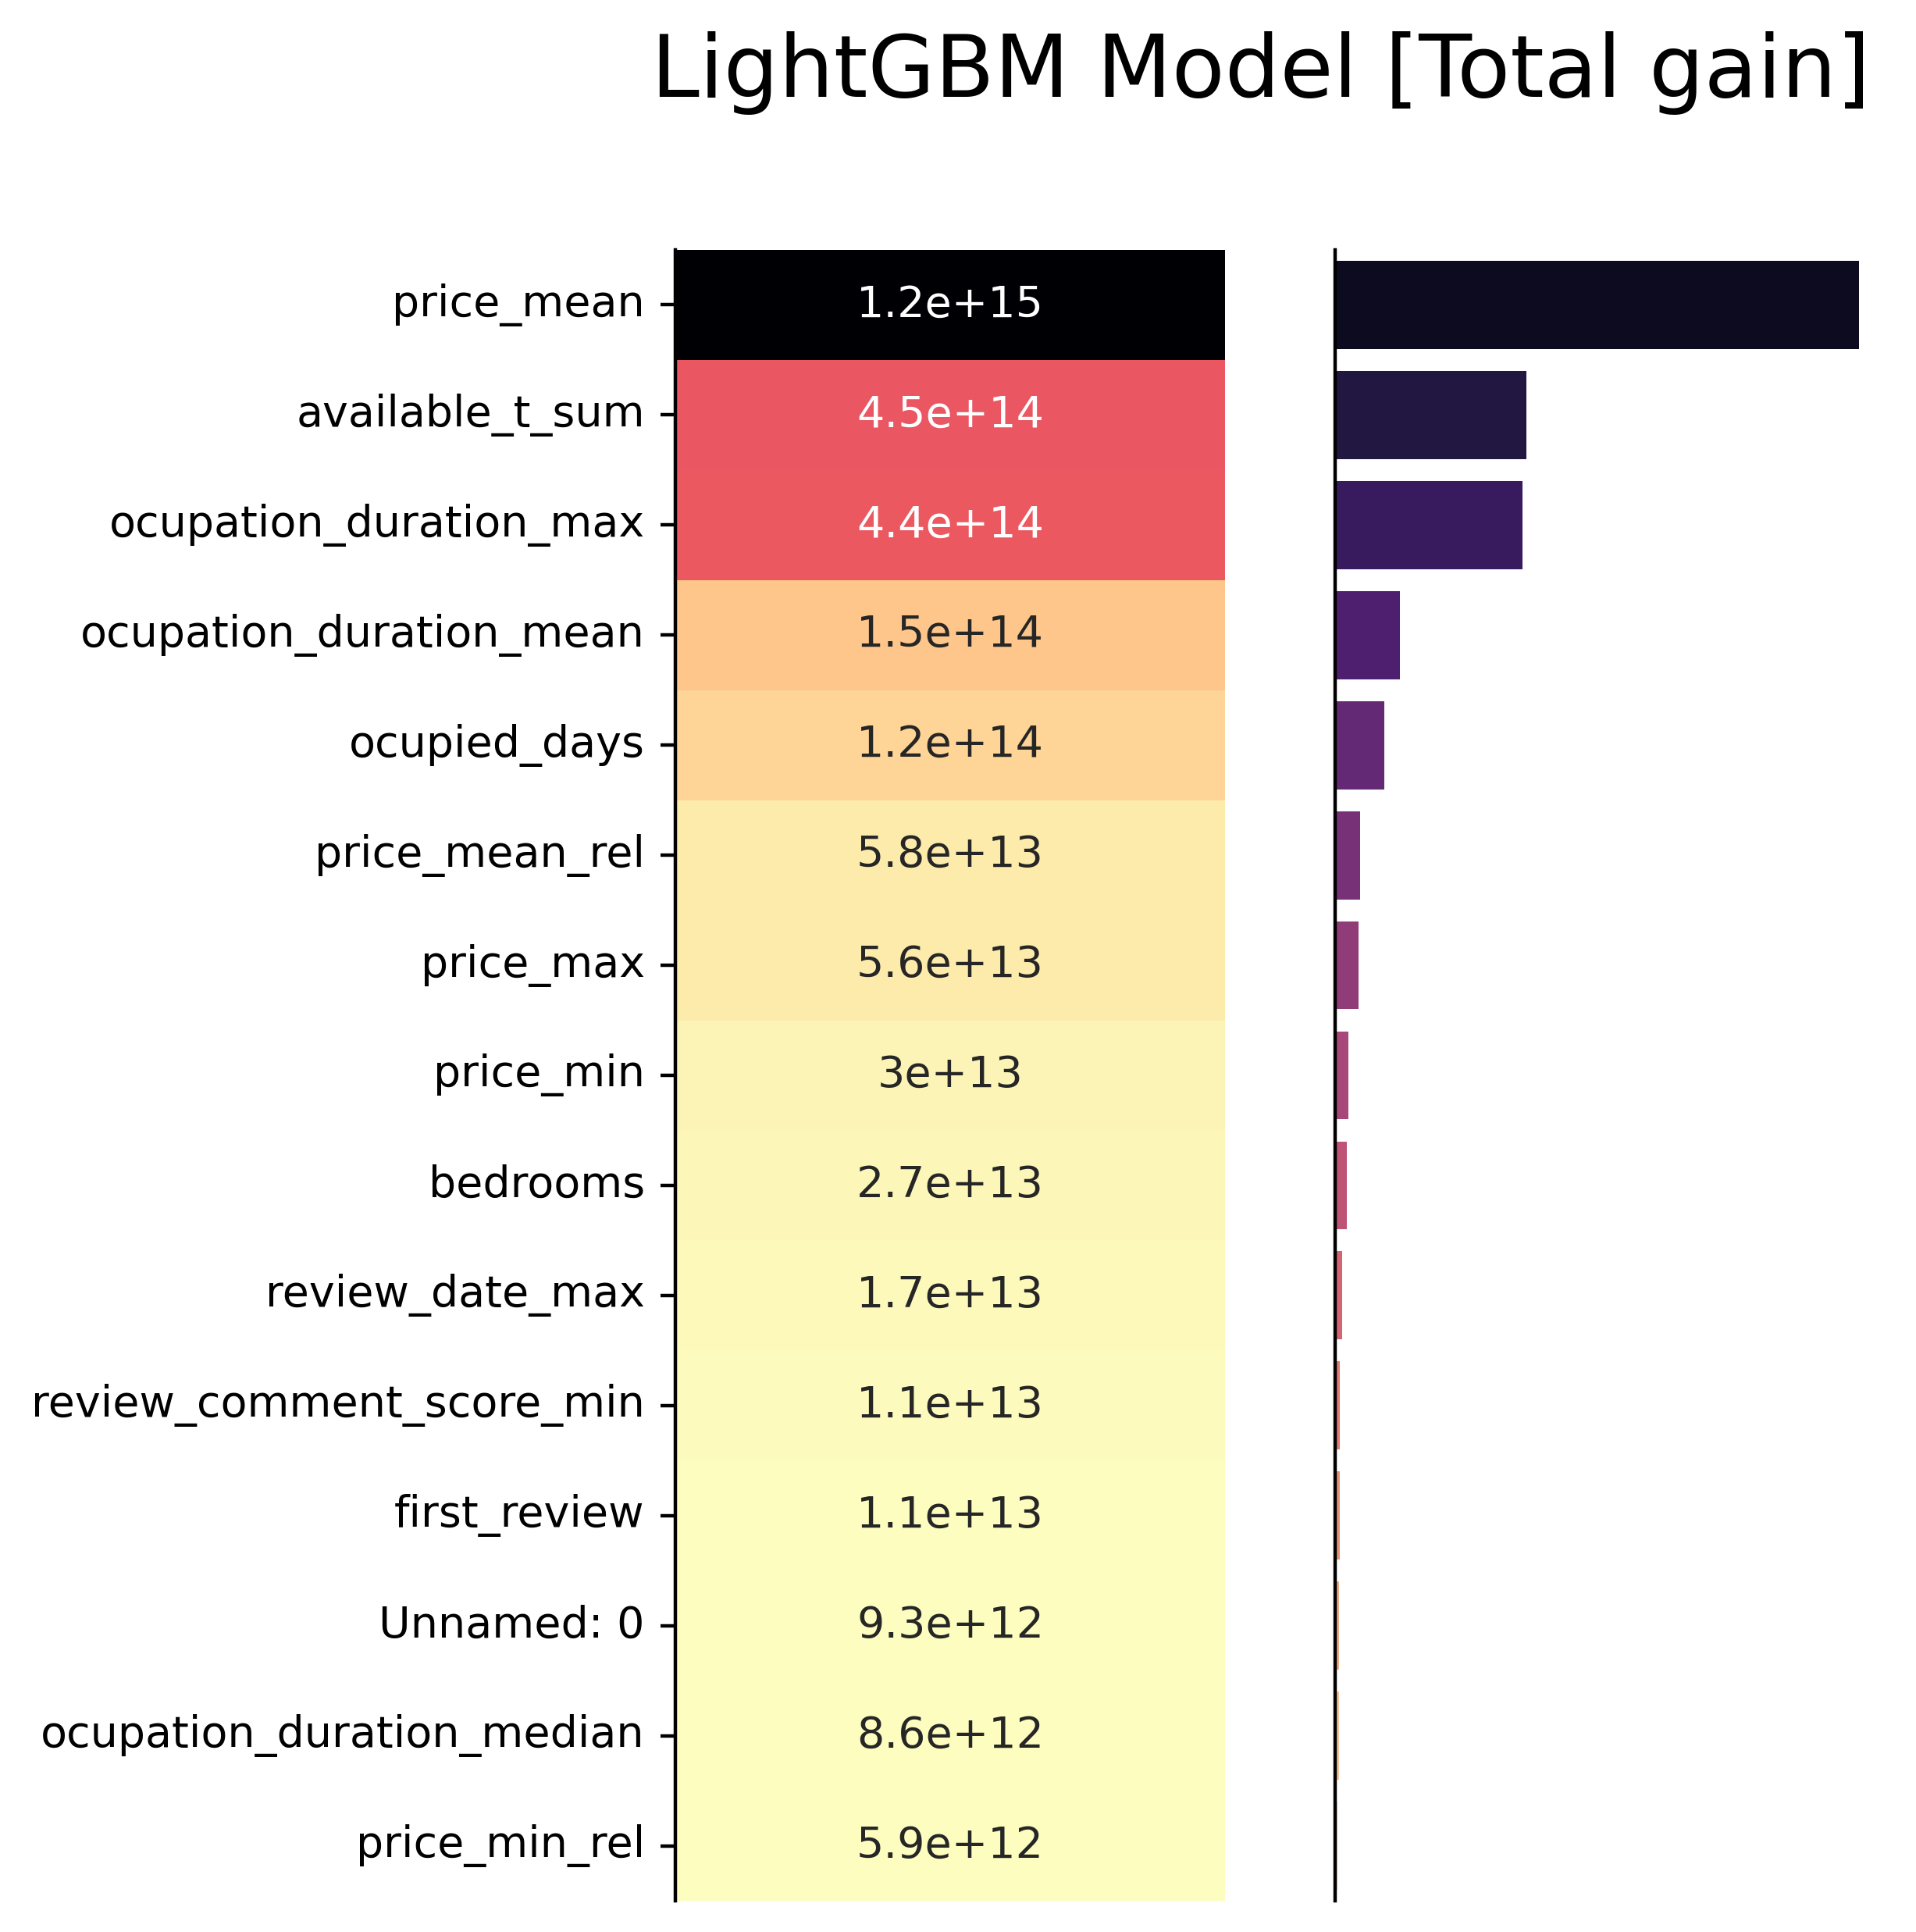

In [68]:
plot_importance(most_important_LightGBM, 'Total gain', 'LightGBM Model [Total gain]')

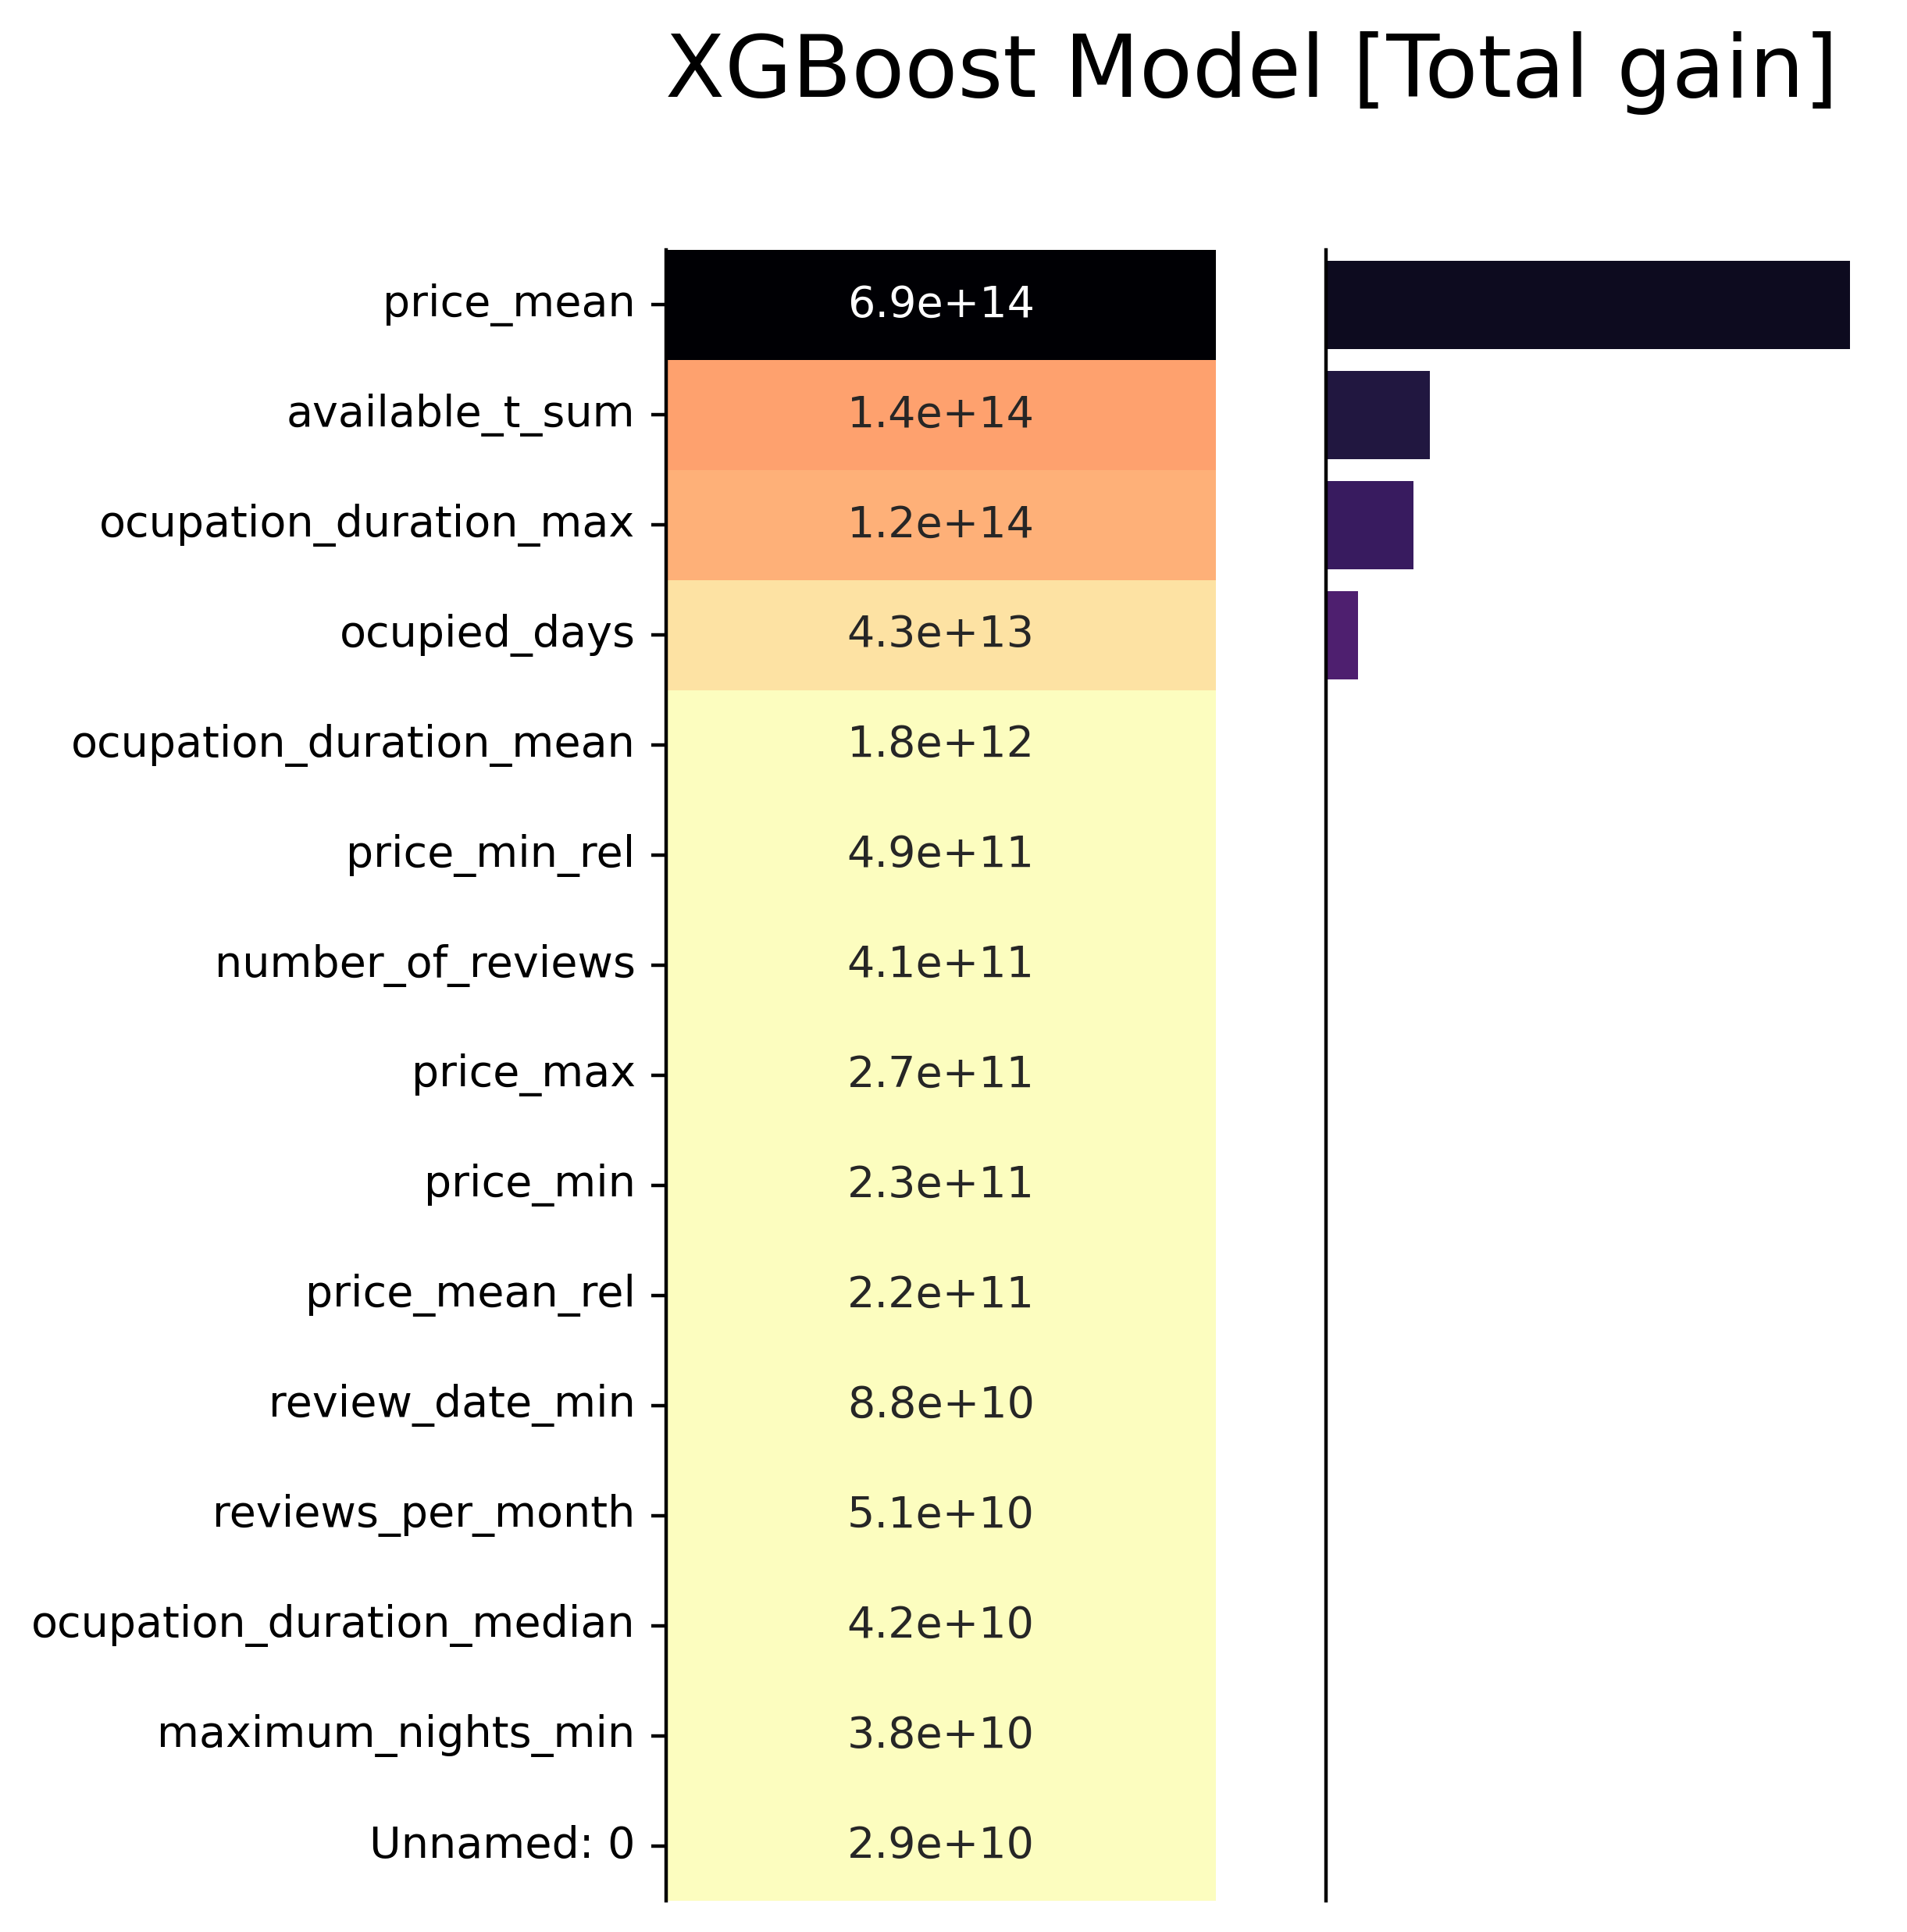

In [69]:
plot_importance(most_important_XGBoost, 'Total gain', 'XGBoost Model [Total gain]')